In [1]:
# Cell 1: Mount Google Drive and install packages
from google.colab import drive
drive.mount('/content/drive')
!pip install torch torchvision torchsummary thop timm opencv-python matplotlib seaborn tqdm scikit-learn tifffile

Mounted at /content/drive


In [2]:
# Cell 2: Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchsummary import summary
from thop import profile
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import time
import glob
from pathlib import Path
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Prefer tifffile if available
try:
    import tifffile
    _READ_TIFF = lambda p: tifffile.imread(p)
except Exception:
    import imageio
    _READ_TIFF = lambda p: imageio.v2.imread(p)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Cell 3: Set random seeds and configuration
torch.manual_seed(42)
np.random.seed(42)

config = {
    'batch_size': 16,
    'learning_rate': 1e-4,
    'epochs': 10,
    'image_size': 224,
    'k_folds': 5
}

In [4]:
# Cell 4: Dataset class for FLAME-3 TIFF images
class Flame3Dataset(Dataset):
    def __init__(self, data_dir, transform=None, percent_clip=(1, 99),
                 target_size=(224, 224), save_converted_dir=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.percent_clip = percent_clip
        self.target_size = target_size
        self.save_converted_dir = Path(save_converted_dir) if save_converted_dir else None

        # Collect paths
        fire_glob = str(self.data_dir / "fire" / "Celsius TIFF" / "*")
        nofire_glob = str(self.data_dir / "nofire" / "Celsius TIFF" / "*")
        self.fire_images = sorted(glob.glob(fire_glob))
        self.non_fire_images = sorted(glob.glob(nofire_glob))

        # Keep only actual files
        self.fire_images = [p for p in self.fire_images if os.path.isfile(p)]
        self.non_fire_images = [p for p in self.non_fire_images if os.path.isfile(p)]

        self.all_images = self.fire_images + self.non_fire_images
        self.labels = [1] * len(self.fire_images) + [0] * len(self.non_fire_images)

        if self.save_converted_dir:
            (self.save_converted_dir / "fire").mkdir(parents=True, exist_ok=True)
            (self.save_converted_dir / "nofire").mkdir(parents=True, exist_ok=True)

        # Default transform
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(self.target_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
            ])

        print(f"[Flame3Dataset] Fire: {len(self.fire_images)}, Non-fire: {len(self.non_fire_images)}, Total: {len(self.all_images)}")

    def __len__(self):
        return len(self.all_images)

    def _read_tiff(self, path):
        arr = _READ_TIFF(path)
        arr = np.asarray(arr).astype(np.float32)
        return arr

    def _to_3channel_uint8_pil(self, arr):
        if arr.ndim == 3:
            arr = arr[..., 0]

        # Handle NaNs/Infs
        arr = np.nan_to_num(arr, nan=np.nanmedian(arr), posinf=np.nanmedian(arr), neginf=np.nanmedian(arr))

        low_p, high_p = self.percent_clip
        vmin = np.percentile(arr, low_p)
        vmax = np.percentile(arr, high_p)

        if vmax <= vmin:
            vmax = arr.max() if arr.max() != vmin else vmin + 1.0

        arr_clipped = np.clip(arr, vmin, vmax)
        arr_norm = (arr_clipped - vmin) / (vmax - vmin)
        arr_255 = (arr_norm * 255.0).round().astype(np.uint8)

        # Make 3-channel
        if arr_255.ndim == 2:
            arr_rgb = np.stack([arr_255, arr_255, arr_255], axis=2)
        else:
            if arr_255.shape[2] >= 3:
                arr_rgb = arr_255[..., :3]
            else:
                arr_rgb = np.concatenate([arr_255] * 3, axis=2)

        pil = Image.fromarray(arr_rgb)
        return pil

    def __getitem__(self, idx):
        path = self.all_images[idx]
        label = int(self.labels[idx])

        # Read and process image
        arr = self._read_tiff(path)
        pil = self._to_3channel_uint8_pil(arr)

        # Apply transform
        img = self.transform(pil)
        return img, label

In [5]:
# Cell 5: Attention Modules
class OptimizedThermalChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        reduced = max(channels // reduction_ratio, 8)

        self.mlp = nn.Sequential(
            nn.Linear(channels, reduced), nn.ReLU(),
            nn.Linear(reduced, reduced), nn.ReLU(),
            nn.Linear(reduced, channels),
        )
        self.bn = nn.BatchNorm1d(channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.size()
        gap = self.gap(x).view(b, c)
        weights = self.mlp(gap)
        weights = self.bn(weights)
        weights = self.sigmoid(weights).view(b, c, 1, 1)
        return x * weights



In [6]:
class OTFAN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # Use MobileNetV4 Conv Small 035 as backbone
        self.backbone = timm.create_model('mobilenetv4_conv_small_035', pretrained=False, num_classes=0)

        # Test to get actual feature channels
        test_input = torch.randn(2, 3, 224, 224)  # Batch size 2 for BatchNorm
        with torch.no_grad():
            test_output = self.backbone(test_input)

        # Determine number of feature channels
        feature_channels = test_output.shape[1]
        print(f"Using mobilenetv4_conv_small_035 with {feature_channels} feature channels")

        # use Thermal Channel Attention (OTCA)
        self.otca = OptimizedThermalChannelAttention(feature_channels)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(feature_channels, num_classes)
        )

    def forward(self, x):
        # Get backbone features
        features = self.backbone(x)  # (B, C) if global pooled

        # Apply channel attention
        otca_features = self.otca(features.unsqueeze(-1).unsqueeze(-1))  # Add spatial dims
        otca_features = otca_features.squeeze(-1).squeeze(-1)  # Remove spatial dims

        # Classifier
        return self.classifier(otca_features)


In [7]:
# Cell 7: Training function with metrics tracking (simplified)
def train_one_fold(model, train_loader, val_loader, epochs=30, fold_num=1):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

    # Track metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0
    best_model_state = None

    print(f"\n{'='*50}")
    print(f"Training Fold {fold_num}")
    print(f"{'='*50}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # Calculate training accuracy
        train_acc = 100. * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # Calculate validation accuracy
        val_acc = 100. * val_correct / val_total

        # Store metrics
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"  ↳ New best! Val Acc: {val_acc:.2f}%")

        # Print epoch results
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:2d}: "
                  f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_acc:.2f}%")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Return model and all metrics
    fold_metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

    return model, fold_metrics

In [8]:
# Cell 8: Updated evaluation function (simplified)
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate all metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

    return metrics, all_preds, all_labels

In [9]:
# Cell 9: Efficiency metrics calculation (with printing)
def calculate_efficiency(model, input_size=(1, 3, 224, 224)):
    print("Calculating efficiency metrics...")

    # Parameters
    total_params = sum(p.numel() for p in model.parameters())

    print(f"  Total parameters: {total_params:,}")

    # FLOPs
    print("  Calculating FLOPs...")
    input_tensor = torch.randn(*input_size).to(device)
    flops, _ = profile(model, inputs=(input_tensor,), verbose=False)

    print(f"  FLOPs: {flops:,.0f}")
    print(f"  MFLOPs: {flops / 1e6:.2f}")

    # Inference speed (FPS)
    print("  Measuring inference speed...")
    model.eval()
    warmup = 10
    test_iterations = 500

    # Warmup
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(input_tensor)

    # Speed test
    start = time.time()
    with torch.no_grad():
        for _ in range(test_iterations):
            _ = model(input_tensor)
    fps = test_iterations / (time.time() - start)

    print(f"  Inference speed: {fps:.2f} FPS")

    # Model size
    print("  Calculating model size...")
    torch.save(model.state_dict(), 'temp_model.pth')
    model_size = os.path.getsize('temp_model.pth') / (1024 * 1024)  # MB
    os.remove('temp_model.pth')

    print(f"  Model size: {model_size:.2f} MB")

    efficiency_metrics = {
        'total_params': total_params,
        'flops': flops,
        'mflops': flops / 1e6,
        'fps': fps,
        'model_size_mb': model_size
    }

    print("Efficiency metrics calculation completed!\n")
    return efficiency_metrics

In [10]:
# Cell 10: Updated visualization function
def plot_training_curves(fold_metrics_list):
    """Plot training curves for all folds"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Training Curves Across Folds', fontsize=16, fontweight='bold')

    # Plot 1: Loss curves
    ax1 = axes[0]
    for fold_num, fold_metrics in enumerate(fold_metrics_list):
        epochs = range(1, len(fold_metrics['train_losses']) + 1)

        ax1.plot(epochs, fold_metrics['train_losses'],
                label=f'Fold {fold_num+1} Train', alpha=0.6, linewidth=1)
        ax1.plot(epochs, fold_metrics['val_losses'],
                label=f'Fold {fold_num+1} Val', alpha=0.6, linewidth=1, linestyle='--')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curves')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', fontsize='small')

    # Plot 2: Accuracy curves
    ax2 = axes[1]
    for fold_num, fold_metrics in enumerate(fold_metrics_list):
        epochs = range(1, len(fold_metrics['train_accs']) + 1)

        ax2.plot(epochs, fold_metrics['train_accs'],
                label=f'Fold {fold_num+1} Train', alpha=0.6, linewidth=1)
        ax2.plot(epochs, fold_metrics['val_accs'],
                label=f'Fold {fold_num+1} Val', alpha=0.6, linewidth=1, linestyle='--')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy Curves')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', fontsize='small')

    plt.tight_layout()
    plt.show()

In [11]:
# Cell 11: Updated metrics summary function
def plot_metrics_summary(final_metrics):
    """Plot summary of all metrics across folds"""
    # Convert to DataFrame for easier plotting
    metrics_data = []
    for fold_name, metrics in final_metrics.items():
        row = [fold_name] + [metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']]
        metrics_data.append(row)

    df = pd.DataFrame(metrics_data, columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('5-Fold Cross Validation Results', fontsize=16, fontweight='bold')

    # 1. Bar plot of average metrics
    ax1 = axes[0, 0]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    mean_values = [df[metric].mean() for metric in metric_names]
    std_values = [df[metric].std() for metric in metric_names]

    bars = ax1.bar(metric_names, mean_values, yerr=std_values, capsize=5,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax1.set_ylabel('Score')
    ax1.set_ylim([0, 1.0])
    ax1.set_title('Average Metrics Across Folds')
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

    # 2. Box plot of metrics distribution
    ax2 = axes[0, 1]
    data_to_plot = [df[metric].values for metric in metric_names]
    box = ax2.boxplot(data_to_plot, labels=metric_names, patch_artist=True)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_ylabel('Score')
    ax2.set_title('Distribution Across Folds')
    ax2.grid(True, alpha=0.3)

    # 3. Line plot of fold-wise performance
    ax3 = axes[1, 0]
    fold_numbers = list(range(1, len(df) + 1))

    for metric in metric_names:
        ax3.plot(fold_numbers, df[metric].values, marker='o', label=metric)

    ax3.set_xlabel('Fold Number')
    ax3.set_ylabel('Score')
    ax3.set_title('Fold-wise Performance')
    ax3.set_xticks(fold_numbers)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Text summary
    ax4 = axes[1, 1]
    ax4.axis('off')  # Hide axes for text display

    summary_text = f"""
    Results Summary:
    {'='*40}

    Mean Accuracy:   {df['Accuracy'].mean():.4f} ± {df['Accuracy'].std():.4f}
    Mean Precision:  {df['Precision'].mean():.4f} ± {df['Precision'].std():.4f}
    Mean Recall:     {df['Recall'].mean():.4f} ± {df['Recall'].std():.4f}
    Mean F1-Score:   {df['F1-Score'].mean():.4f} ± {df['F1-Score'].std():.4f}

    {'='*40}
    Best Fold:       Fold {df['Accuracy'].idxmax() + 1}
    Worst Fold:      Fold {df['Accuracy'].idxmin() + 1}
    """

    ax4.text(0.1, 0.5, summary_text, fontsize=12,
             verticalalignment='center', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

    return df

In [12]:
def plot_confusion_matrices(all_cms):
    """Plot confusion matrices for all folds"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Confusion Matrices Across Folds', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    for i in range(len(all_cms)):
        ax = axes[i]
        cm = all_cms[i]

        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create heatmap
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                   xticklabels=['Non-Fire', 'Fire'],
                   yticklabels=['Non-Fire', 'Fire'], ax=ax)

        ax.set_title(f'Fold {i+1}')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')

    # Hide empty subplots
    for i in range(len(all_cms), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
# Cell 12: Updated main cross-validation function
def main_cross_validation():
    # Load dataset
    print("Loading FLAME-3 dataset...")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    data_dir = "/content/drive/MyDrive/colab-and-rstudio-datasets/flame3"
    dataset = Flame3Dataset(data_dir, transform=transform)

    # Get labels for stratification
    labels = np.array(dataset.labels)
    print(f"Dataset loaded: {len(dataset)} images")
    print(f"Class distribution: {sum(labels)} fire, {len(labels)-sum(labels)} non-fire")

    # Setup k-fold cross validation
    k_folds = 5
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Storage for results
    all_metrics = []
    all_confusion_matrices = []
    fold_metrics_list = []
    final_metrics = {}

    print(f"\n{'='*60}")
    print(f"STARTING {k_folds}-FOLD CROSS VALIDATION")
    print(f"{'='*60}")

    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n{'='*60}")
        print(f"FOLD {fold + 1}/{k_folds}")
        print(f"{'='*60}")

        # Create data subsets
        train_dataset = Subset(dataset, train_idx)
        val_dataset = Subset(dataset, val_idx)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                                shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'],
                              shuffle=False, num_workers=2)

        # Create model
        model = OTFAN(num_classes=2).to(device)

        # Train model
        trained_model, fold_metrics = train_one_fold(
            model, train_loader, val_loader,
            epochs=config['epochs'], fold_num=fold+1
        )

        # Store training metrics
        fold_metrics_list.append(fold_metrics)

        # Evaluate on validation set (for final metrics)
        val_metrics, _, _ = evaluate_model(trained_model, val_loader)

        # Store results
        all_metrics.append(val_metrics)
        all_confusion_matrices.append(val_metrics['confusion_matrix'])
        final_metrics[f'Fold {fold+1}'] = {
            'accuracy': val_metrics['accuracy'],
            'precision': val_metrics['precision'],
            'recall': val_metrics['recall'],
            'f1_score': val_metrics['f1_score']
        }

        print(f"\nFold {fold+1} Results:")
        print(f"  Accuracy:  {val_metrics['accuracy']:.4f}")
        print(f"  Precision: {val_metrics['precision']:.4f}")
        print(f"  Recall:    {val_metrics['recall']:.4f}")
        print(f"  F1-Score:  {val_metrics['f1_score']:.4f}")

    # Calculate efficiency metrics (use first fold's model)
    print(f"\n{'='*60}")
    print("CALCULATING EFFICIENCY METRICS")
    print(f"{'='*60}")

    sample_model = OTFAN(num_classes=2).to(device)
    efficiency_metrics = calculate_efficiency(sample_model)

    # Visualize results
    print(f"\n{'='*60}")
    print("GENERATING VISUALIZATIONS")
    print(f"{'='*60}")

    plot_training_curves(fold_metrics_list)
    plot_confusion_matrices(all_confusion_matrices)
    metrics_df = plot_metrics_summary(final_metrics)

    # Print final results
    print("\n" + "="*60)
    print("FINAL 5-FOLD CROSS VALIDATION RESULTS")
    print("="*60)
    print("\nDetailed Metrics:")
    print(metrics_df.to_string(index=False))

    # Return all results
    results = {
        'final_metrics': final_metrics,
        'metrics_df': metrics_df,
        'confusion_matrices': all_confusion_matrices,
        'fold_metrics': fold_metrics_list,
        'efficiency_metrics': efficiency_metrics
    }

    return results

Loading FLAME-3 dataset...
[Flame3Dataset] Fire: 622, Non-fire: 116, Total: 738
Dataset loaded: 738 images
Class distribution: 622 fire, 116 non-fire

STARTING 5-FOLD CROSS VALIDATION

FOLD 1/5
Using mobilenetv4_conv_small_035 with 1280 feature channels

Training Fold 1


Epoch 1/10: 100%|██████████| 37/37 [01:04<00:00,  1.74s/it]


  ↳ New best! Val Acc: 85.14%
Epoch  1: Train Loss: 0.5144, Acc: 81.53%, Val Loss: 0.5001, Acc: 85.14%


Epoch 2/10: 100%|██████████| 37/37 [00:13<00:00,  2.66it/s]


  ↳ New best! Val Acc: 92.57%


Epoch 3/10: 100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


  ↳ New best! Val Acc: 96.62%


Epoch 5/10: 100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


  ↳ New best! Val Acc: 97.97%
Epoch  5: Train Loss: 0.2777, Acc: 95.42%, Val Loss: 0.2475, Acc: 97.97%


Epoch 9/10: 100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


  ↳ New best! Val Acc: 99.32%


Epoch 10/10: 100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 10: Train Loss: 0.2556, Acc: 97.29%, Val Loss: 0.2290, Acc: 98.65%

Fold 1 Results:
  Accuracy:  0.9865
  Precision: 0.9843
  Recall:    1.0000
  F1-Score:  0.9921

FOLD 2/5
Using mobilenetv4_conv_small_035 with 1280 feature channels

Training Fold 2


Epoch 1/10: 100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


  ↳ New best! Val Acc: 89.86%
Epoch  1: Train Loss: 0.4843, Acc: 83.56%, Val Loss: 0.4721, Acc: 89.86%


Epoch 2/10: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


  ↳ New best! Val Acc: 97.97%


Epoch 5/10: 100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch  5: Train Loss: 0.2836, Acc: 95.08%, Val Loss: 0.2539, Acc: 95.95%


Epoch 10/10: 100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 10: Train Loss: 0.2487, Acc: 97.29%, Val Loss: 0.2489, Acc: 96.62%

Fold 2 Results:
  Accuracy:  0.9662
  Precision: 0.9688
  Recall:    0.9920
  F1-Score:  0.9802

FOLD 3/5
Using mobilenetv4_conv_small_035 with 1280 feature channels

Training Fold 3


Epoch 1/10: 100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


  ↳ New best! Val Acc: 86.49%
Epoch  1: Train Loss: 0.5112, Acc: 82.71%, Val Loss: 0.5090, Acc: 86.49%


Epoch 2/10: 100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


  ↳ New best! Val Acc: 93.24%


Epoch 3/10: 100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


  ↳ New best! Val Acc: 94.59%


Epoch 5/10: 100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch  5: Train Loss: 0.2799, Acc: 93.90%, Val Loss: 0.2702, Acc: 94.59%


Epoch 6/10: 100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


  ↳ New best! Val Acc: 95.95%


Epoch 7/10: 100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


  ↳ New best! Val Acc: 97.30%


Epoch 10/10: 100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 10: Train Loss: 0.2750, Acc: 95.25%, Val Loss: 0.3206, Acc: 95.27%

Fold 3 Results:
  Accuracy:  0.9527
  Precision: 0.9606
  Recall:    0.9839
  F1-Score:  0.9721

FOLD 4/5
Using mobilenetv4_conv_small_035 with 1280 feature channels

Training Fold 4


Epoch 1/10: 100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


  ↳ New best! Val Acc: 84.35%
Epoch  1: Train Loss: 0.5412, Acc: 80.54%, Val Loss: 0.5212, Acc: 84.35%


Epoch 2/10: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


  ↳ New best! Val Acc: 86.39%


Epoch 4/10: 100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


  ↳ New best! Val Acc: 90.48%


Epoch 5/10: 100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


  ↳ New best! Val Acc: 91.16%
Epoch  5: Train Loss: 0.3195, Acc: 93.06%, Val Loss: 0.3099, Acc: 91.16%


Epoch 6/10: 100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


  ↳ New best! Val Acc: 93.88%


Epoch 7/10: 100%|██████████| 37/37 [00:10<00:00,  3.42it/s]


  ↳ New best! Val Acc: 94.56%


Epoch 9/10: 100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


  ↳ New best! Val Acc: 97.28%


Epoch 10/10: 100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 10: Train Loss: 0.2562, Acc: 98.14%, Val Loss: 0.2630, Acc: 95.92%

Fold 4 Results:
  Accuracy:  0.9592
  Precision: 0.9683
  Recall:    0.9839
  F1-Score:  0.9760

FOLD 5/5
Using mobilenetv4_conv_small_035 with 1280 feature channels

Training Fold 5


Epoch 1/10: 100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


  ↳ New best! Val Acc: 86.39%
Epoch  1: Train Loss: 0.4758, Acc: 84.09%, Val Loss: 0.4980, Acc: 86.39%


Epoch 2/10: 100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


  ↳ New best! Val Acc: 91.84%


Epoch 4/10: 100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


  ↳ New best! Val Acc: 93.20%


Epoch 5/10: 100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


  ↳ New best! Val Acc: 95.24%
Epoch  5: Train Loss: 0.3055, Acc: 94.08%, Val Loss: 0.2724, Acc: 95.24%


Epoch 6/10: 100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


  ↳ New best! Val Acc: 97.28%


Epoch 10/10: 100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 10: Train Loss: 0.2720, Acc: 96.28%, Val Loss: 0.2491, Acc: 97.28%

Fold 5 Results:
  Accuracy:  0.9728
  Precision: 0.9688
  Recall:    1.0000
  F1-Score:  0.9841

CALCULATING EFFICIENCY METRICS
Using mobilenetv4_conv_small_035 with 1280 feature channels
Calculating efficiency metrics...
  Total parameters: 842,146
  Calculating FLOPs...
  FLOPs: 46,681,280
  MFLOPs: 46.68
  Measuring inference speed...
  Inference speed: 201.31 FPS
  Calculating model size...
  Model size: 3.51 MB
Efficiency metrics calculation completed!


GENERATING VISUALIZATIONS


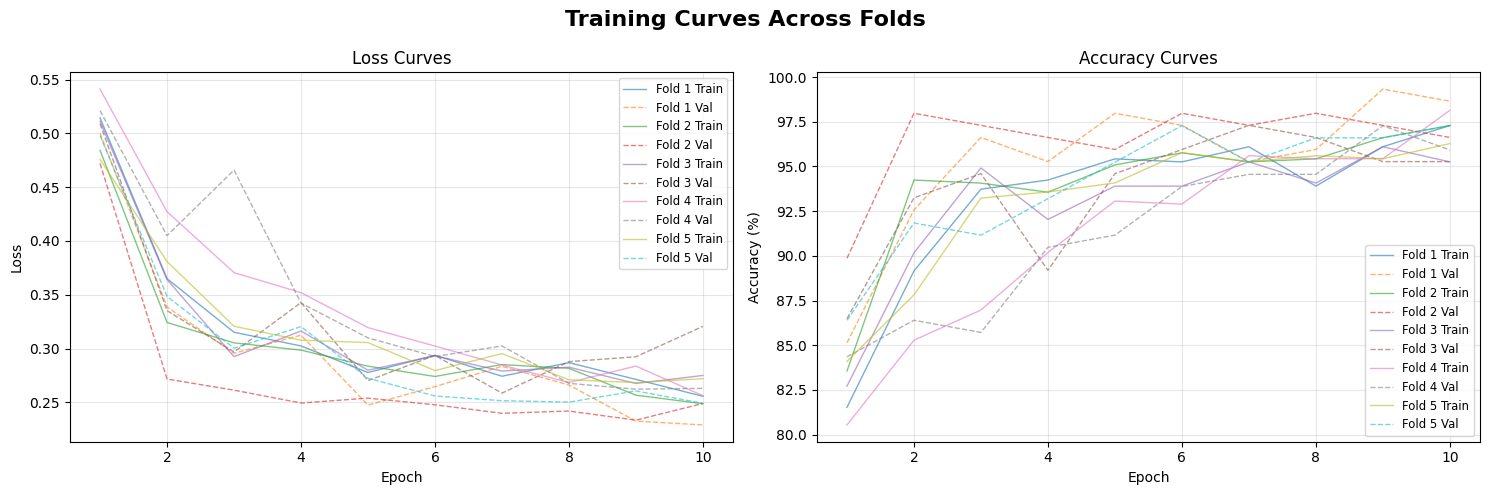

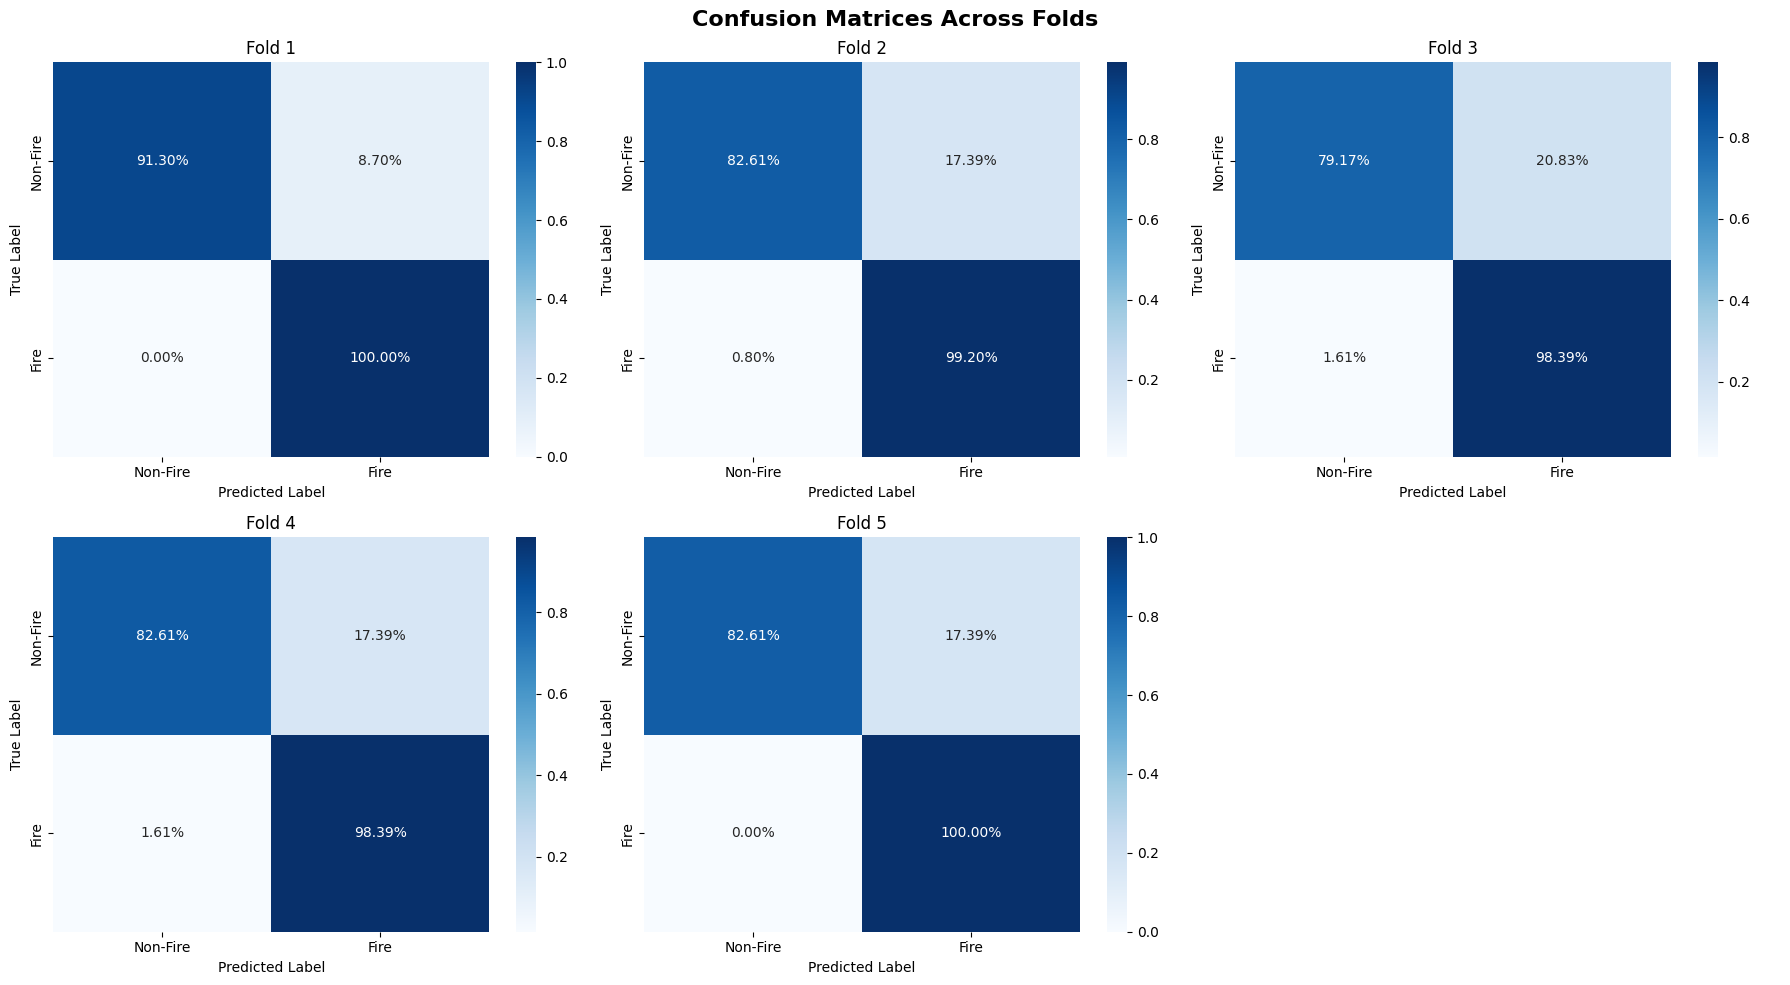

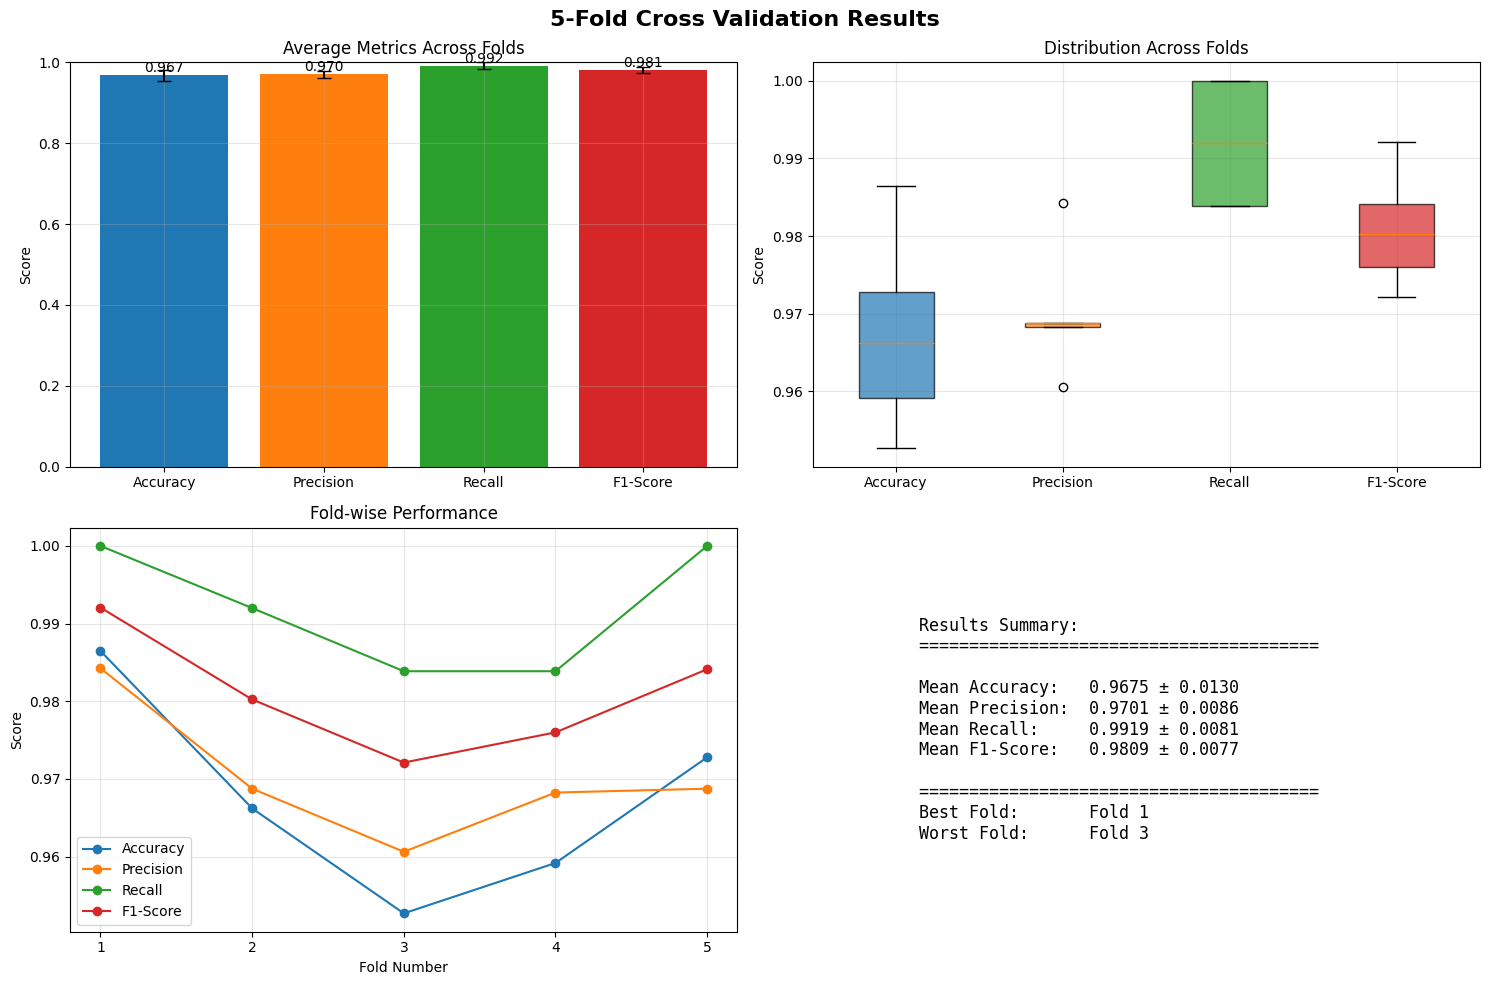


FINAL 5-FOLD CROSS VALIDATION RESULTS

Detailed Metrics:
  Fold  Accuracy  Precision   Recall  F1-Score
Fold 1  0.986486   0.984252 1.000000  0.992063
Fold 2  0.966216   0.968750 0.992000  0.980237
Fold 3  0.952703   0.960630 0.983871  0.972112
Fold 4  0.959184   0.968254 0.983871  0.976000
Fold 5  0.972789   0.968750 1.000000  0.984127

SAVING RESULTS
Results saved to 'cross_validation_results.csv'
Confusion matrices saved to 'confusion_matrices.npy'
Efficiency metrics saved to 'efficiency_metrics.csv'

PROCESS COMPLETED SUCCESSFULLY!


In [14]:
# Cell 13: Updated run pipeline
if __name__ == "__main__":
    results = main_cross_validation()

    # Save results
    print(f"\n{'='*60}")
    print("SAVING RESULTS")
    print(f"{'='*60}")

    # Save metrics to CSV
    results['metrics_df'].to_csv('cross_validation_results.csv', index=False)
    print("Results saved to 'cross_validation_results.csv'")

    # Save confusion matrices
    np.save('confusion_matrices.npy', results['confusion_matrices'])
    print("Confusion matrices saved to 'confusion_matrices.npy'")

    # Save efficiency metrics
    eff_df = pd.DataFrame([results['efficiency_metrics']])
    eff_df.to_csv('efficiency_metrics.csv', index=False)
    print("Efficiency metrics saved to 'efficiency_metrics.csv'")

    print(f"\n{'='*60}")
    print("PROCESS COMPLETED SUCCESSFULLY!")
    print(f"{'='*60}")

In [15]:
!pip install graphviz

In [16]:
from graphviz import Digraph

def create_architecture_diagram():
    # Initialize the graph
    dot = Digraph(comment='OTFAN Architecture', format='png')

    # SETTINGS FOR SQUARE/COMPACT LAYOUT
    # rankdir='TB' means the main flow is Top-to-Bottom
    # splines='ortho' makes edges turn at right angles (cleaner)
    dot.attr(rankdir='TB', splines='ortho', ranksep='0.6', nodesep='0.2')

    # Node Styling
    dot.attr('node', shape='box', style='filled', fillcolor='white',
             fontname='Helvetica', fontsize='16', penwidth='1.5')
    dot.attr('edge', fontname='Helvetica', fontsize='18', penwidth='1.2')

    # ============================================================
    # ROW 1: Input -> Backbone (Horizontal Group)
    # ============================================================
    with dot.subgraph(name='cluster_Row1') as row1:
        row1.attr(style='invis') # Invisible container
        with row1.subgraph() as s:
            s.attr(rank='same')  # Force these to be on the same horizontal level
            s.node('Input', 'Input Image\n(3 x 224 x 224)', shape='oval', fillcolor='#E3F2FD')
            s.node('Backbone', 'MobileNetV4\nConv Small 035\n(Feature Extractor)',
                   fillcolor='#FFF3E0', height='1.0')
            # Connection is defined later, but layout is forced here

    # ============================================================
    # ROW 2: Global Features (Center)
    # ============================================================
    dot.node('Features', 'Global Features\n(1280 channels)', shape='plaintext',
             style='', fontcolor='gray20')

    # ============================================================
    # ROW 3: OTCA Module (Complex Block)
    # ============================================================
    with dot.subgraph(name='cluster_OTCA') as otca:
        otca.attr(label='Optimized Thermal Channel Attention (OTCA)', color='gray30', style='dashed',
                 fontcolor='gray20', labeljust='c')

        otca.node('GAP', 'Global Avg Pool', fillcolor='#F3E5F5')

        # --- MLP SUB-BLOCK (Horizontal Chain) ---
        with otca.subgraph(name='cluster_MLP') as mlp:
            mlp.attr(label='MLP Layers', color='gray30', style='solid', fontcolor='gray20')
            # Force MLP nodes to be horizontal to widen the graph
            with mlp.subgraph() as s_mlp:
                s_mlp.attr(rank='same')
                s_mlp.node('L1', 'Linear\n(1280→80)', fillcolor='#E8F5E9')
                s_mlp.node('R1', 'ReLU', shape='circle', width='0.7', fixedsize='true')
                s_mlp.node('L2', 'Linear\n(80→80)', fillcolor='#E8F5E9')
                s_mlp.node('R2', 'ReLU', shape='circle', width='0.7', fixedsize='true')
                s_mlp.node('L3', 'Linear\n(80→1280)', fillcolor='#E8F5E9')

                # Connect MLP internally (Horizontal)
                s_mlp.edge('L1', 'R1')
                s_mlp.edge('R1', 'L2')
                s_mlp.edge('L2', 'R2')
                s_mlp.edge('R2', 'L3')

        otca.node('BN', 'BatchNorm1d', fillcolor='#FFF8E1')
        otca.node('Sigmoid', 'Sigmoid', shape='circle', width='1', fixedsize='true', fillcolor='#E1F5FE')

        # Using 'x' instead of unicode symbol for compatibility
        otca.node('Mul', 'x', shape='circle', width='0.6', fixedsize='true',
                 fontsize='16', fillcolor='white', fontname='Arial')

        # --- Internal OTCA Vertical Connections ---
        # GAP goes down to the start of MLP (L1)
        otca.edge('GAP', 'L1')

        # End of MLP (L3) goes down to BN
        otca.edge('L3', 'BN')

        # Vertical stack for the rest
        otca.edge('BN', 'Sigmoid')
        otca.edge('Sigmoid', 'Mul', label=' Attention\nWeights')

    # ============================================================
    # ROW 4: Classifier Head (Horizontal Group)
    # ============================================================
    with dot.subgraph(name='cluster_Head') as head:
        head.attr(style='invis')
        with head.subgraph() as s_head:
            s_head.attr(rank='same') # Force horizontal layout
            s_head.node('Dropout', 'Dropout\n(p=0.2)', fillcolor='#FFEBEE')
            s_head.node('FC_Final', 'Linear Classifier\n(1280→2)', fillcolor='#FFCDD2')
            s_head.node('Output', 'Output\n(Fire/No-Fire)', shape='oval', fillcolor='#E3F2FD')

            # Connect Head internally
            s_head.edge('Dropout', 'FC_Final')
            s_head.edge('FC_Final', 'Output', label='Logits')

    # ============================================================
    # MAIN CONNECTIVITY (Stitching the rows)
    # ============================================================

    # Row 1 connection
    dot.edge('Input', 'Backbone')

    # Row 1 -> Row 2
    dot.edge('Backbone', 'Features')

    # Row 2 -> Row 3
    dot.edge('Features', 'GAP', label=' Input')

    # Residual Skip Connection (Features -> Mul)
    # constraint='false' allows this edge to curve around the MLP block
    # without forcing Mul to be directly below Features, keeping the layout compact.
    dot.edge('Features', 'Mul', style='dashed', constraint='false')

    # Row 3 -> Row 4
    dot.edge('Mul', 'Dropout', label='Refined\n Features')

    # Render
    output_filename = 'OTFAN_Architecture'
    # view=False avoids errors in notebooks; cleanup=True removes the source .dot file
    dot.render(output_filename, view=False, cleanup=True)
    print(f"Diagram saved as {output_filename}.png")

if __name__ == "__main__":
    create_architecture_diagram()

Diagram saved as OTFAN_Architecture.png
